<a href="_index.ipynb">&larr; LAB </a>&loz;
<a href="../../README.md"> &uarr; TOC &uarr; </a>
<img src='../_img/icon.svg' align='right' width='10%'></img>

<b>Name, Vorname:</b> 
# LAB 2a: Filterung und DFT als Näherung für spektrale Analyse (Nachtrag)
Dieser Teil von LAB 2 ist nicht rechtzeitig fertig geworden, Sie können ihn gemeinsam mit LAB 2 oder mit LAB 3 abgeben.

### Inhalt
[0. Allgemeines](#allgemeines)

[4. Fourierspektrum eines Rechteckpulses](#fourierspektrum)

## 0. Allgemeine Hinweise<a id='allgemeines'></a>

* \<SHIFT\>-\<RETURN\> führt eine Codezelle aus und rendert eine Textzelle.
* In Markdown sind Leerzeilen wichtig zum Trennen von Abschnitten! 
* Sie können LaTeX-Code zwischen \\$ ... \\$ einschließen.
* Kontexthilfe zu Funktionen etc. bekommen Sie über \<SHIFT\>-\<TAB\>

Nach dem Praktikumsversuch exportieren Sie das Notebook mit Textantworten, Codezellen und Plots als HTML (File -> Export Notebook As ... -> Export Notebook to HTML) und reichen es in Moodle ein.</div><br />

***

In [23]:
import os, sys
module_path = os.path.abspath(os.path.join('..')) # append directory one level up to import path
if module_path not in sys.path:  # ... if it hasn't been appended already
    sys.path.append(module_path)
import dsp_fpga_lib as dsp
dsp.versions() # print versions 
    
%matplotlib inline
import matplotlib.pyplot as plt
size = {"figsize":(12,5)} # Plotgröße in Inch

import numpy as np
import scipy.signal as sig
import wave

from IPython.display import Audio, display
#-----------------------------------------------------------------------------
def wav2np(filename):
    """ Read the wav-file and convert it to a one or two-dimensional numpy array,
        depending on the number of channels. 
        Properties of the WAV-file are stored as function attributes (evil)
    """
    wf = wave.open(filename,'rb')
    wav2np.N_CH = wf.getnchannels() # number of channels
    wav2np.W    = wf.getsampwidth() # wordlength per sample in bytes
    wav2np.N_FR = wf.getnframes()   # number of frames
    wav2np.f_S  = wf.getframerate() # sample (frame) rate 
    
    print("{0} channels with {1} frames of {2} bytes and f_S = {3} Hz.".format(wav2np.N_CH, wav2np.N_FR, wav2np.W, wav2np.f_S))
    
    if wav2np.W == 2:
        samples_in = np.frombuffer(wf.readframes(-1), dtype=np.int16) # read wav data as 16 bit integers, R and L samples are interleaved
    elif wav2np.W == 1:
        samples_in = np.frombuffer(wf.readframes(-1), dtype=np.int8) # read wav data as 8 bit integers, R and L samples are interleaved
    else:
         raise TypeError("Unknown data format: {0} bytes".format(wav2np.W))   

    samples = np.array([samples_in[idx::wav2np.N_CH] for idx in range(wav2np.N_CH)], dtype=np.int32) # deinterleave channels to numpy array N_CHAN x N_FRAMES
    return samples


Python version: 3.7.4
Numpy: 1.19.2
Scipy: 1.5.2
Matplotlib: 3.2.2 module://ipykernel.pylab.backend_inline


## 4. Schätzung des Fourierspektrums eines rechteckförmigen Impulses durch FFT<a id='fourierspektrum'></a>
In diesem Versuchsteil schätzen wir das Fourierintegral des rechteckförmigen Impulses $y(t)$ mit $\Delta T = 250 \,\mu$s und $A = 1000\,\text{mV}$ (s. nächster Plot) mit Hilfe der FFT.
### 4.1 Berechnung der Fouriertransformierten

<div class="alert alert-block alert-info"><b>VORBEREITUNG:</b></div>

* Berechnen Sie die Fouriertransformierte des Impulses und skizzieren Sie die Betragsfunktion (oder plotten Sie sie).

* Bei welcher Frequenz hat die Fouriertransformierte die erste Nullstelle?

  Die erste Nullstelle $f_0$ der Fouriertransformierten ist bei $\pi f_0 \Delta T_1 = \pi \;\Rightarrow \; f_0 = 1/ \Delta T = 4\, \text{kHz}$.

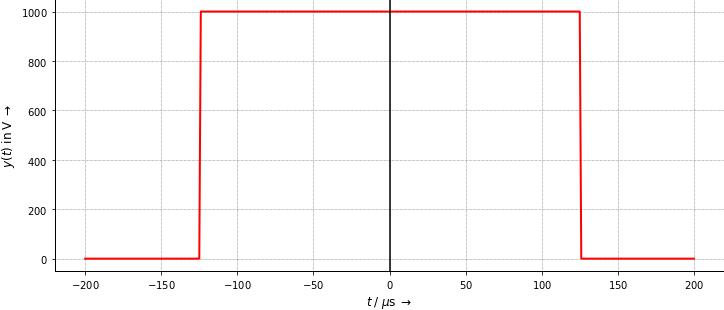

In [24]:
fig, ax = plt.subplots(**size)
Delta_T = 250e-6
A = 1000
t = np.arange(-200e-6, 200e-6, 1e-6)
ax.plot(t*1e6, A*np.where((t >= -Delta_T/2) & (t < Delta_T/2), 1, 0), 'r', lw=2)
ax.axvline(0, ls='-',color='k')
ax.set_xlabel(r"$t \; / \;\mu\mathrm{s} \;\rightarrow$")
ax.set_ylabel(r"$y(t) \; \mathrm{in \;mV} \;\rightarrow$");

Das zeitkontinuierliche Signal $y(t)$ hat eine endliche zeitliche Ausdehnung und endliche Energie, daher kann sein Amplitudenspektrum mit dem Fourierintegral beschrieben werden:

$$Y\left( f \right) = \int_{-\infty}^{\infty}y(t)\text{e}^{-\text{j} 2 \pi f t} \text {d}t$$

Der Impuls ist symmetrisch zur y-Achse was die Berechnung deutlich vereinfacht:

$$
\begin{align}
Y\left( f \right) &= A \int_{-\Delta T/2}^{\Delta T/2}\text{e}^{-\text{j} 2 \pi f t} \text {d}t  = \ldots
\end{align}$$
Das Ergebnis ist die Amplitudenspektrumsdichte in V/Hz.

Berechnet man die FFT anstatt des Fourierintegrals, überstreicht jeder Frequenzpunkt die Bandbreite $\Delta f = f_S/N$. Möchte man die FFT eines Energiesignals so skalieren dass man (in etwa) identische Zahlenwerte erhält wie bei der spektralen Amplitudendichte des ursprünglichen zeitkontinuierlichen Signals, so muss man mit $1/\Delta f = N/f_S$ multiplizieren. Da die FFT bereits mit $1/N$ skaliert ist, hebt sich der Faktor $N$ auf. Man muss also nur durch $f_S$ dividieren.

Für unendlich ausgedehnte Leistungssignale (periodische Signale, stationäre und nicht-stationäre Prozesse) konvergiert das Integral nicht, man nimmt stattdessen die Fourierreihe (periodische Signale) oder die spektrale Leistungsdichte, die über die Autokorrelationsfunktion berechnet wird (aber nicht hier und jetzt ...).

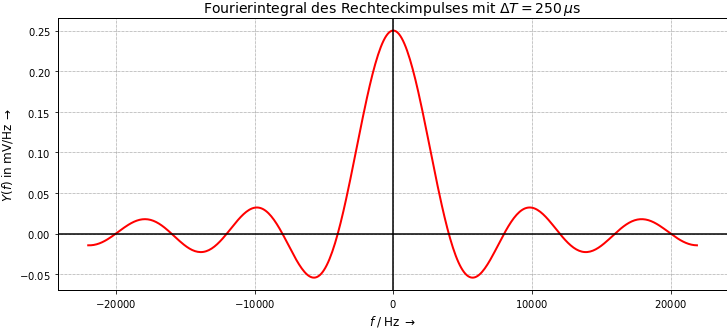

In [56]:
fig, ax = plt.subplots(**size)
Delta_T = 250e-6
A = 1000
f = np.arange(-2.2e4, 2.2e4, 1e2)
ax.plot(f, A * Delta_T*np.sinc(f * Delta_T), 'r', lw=2)
ax.axvline(0, ls='-',color='k'); ax.axhline(0, ls='-',color='k') 
ax.set_title(r"Fourierintegral des Rechteckimpulses mit $\Delta T = 250\, \mu \mathrm{s}$")
ax.set_xlabel(r"$f \; / \;\mathrm{Hz} \;\rightarrow$")
ax.set_ylabel(r"$Y(f) \; \mathrm{in \;mV/Hz} \;\rightarrow$");

### 4.2 Schätzung der Fouriertransformierten mit Hilfe der FFT
Im folgenden soll die Fouriertransformierte des Impulses mit Hilfe einer FFT abgeschätzt werden, dazu wird der Impuls mit $L = 16$ Samples abgetastet.

<div class="alert alert-block alert-info"><b>VORBEREITUNG:</b></div>

* Welche Abtastfrequenz $f_S$ ist dazu notwendig?
  
* Wie groß ist die Frequenzauflösung $\Delta f$? Wieviele Frequenzpunkte erhält man zwischen $f=0$ und der ersten Nullstelle $f_0$?
  
* Kann man die graphische Darstellung des Amplitudenspektrums zwischen $f= 0$ und der ersten Nullstelle $f_0$ durch Änderung der Abtastfrequenz verbessern?
  
* Wie kann die graphische Darstellung des Betragsgangs verbessert werden ohne die Abtastfrequenz zu verändern?

* Wie müssen die Ergebnisse skaliert werden, um gleiche (ähnliche) Werte für die spektrale Amplitudendichte in V/Hz zu bekommen wie theoretisch berechnet? Siehe auch die Anmerkungen zur Berechnung und Skalierung der Fouriertransformierten unter 4.1.

<div class="alert alert-block alert-warning"><b> SIMULATION:</b></div>

* Berechnen Sie die FFT des Rechteckpulses mit $L=16$ und mit $N_{FFT} = 2^9 = 512$ Punkten.

* Plotten Sie die FFT mit $L=16$ Punkten, $N_{FFT} = 512$ Punkten und das ideale Amplitudenspektrum in einen Plot


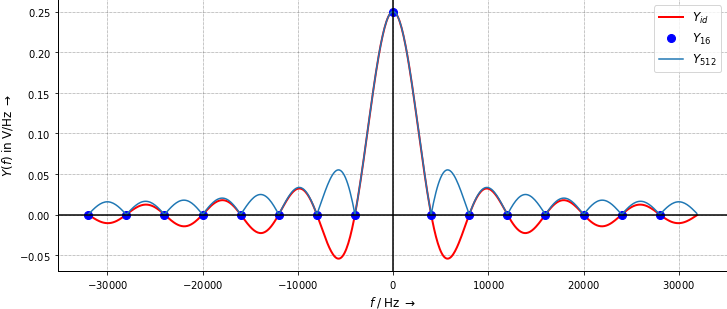

In [50]:
fig, ax = plt.subplots(**size)
f_S = 64e3
Delta_T = 250e-6
A = 1000
f = np.arange(-32e3, 32e3, 1e2)
f_16 = 
f_512 = 
y_id = A * Delta_T*np.sinc(f * Delta_T)
y_16 = 
Y_16 =
Y_512 = 
ax.plot(f, y_id, 'r', lw=2, label="$Y_{id}$")
ax.plot(f_16, Y_16, 'bo', label="$Y_{16}$")
ax.plot(f_512, Y_512, label="$Y_{512}$")
ax.legend()
ax.axvline(0, ls='-',color='k'); ax.axhline(0, ls='-',color='k') 
ax.set_xlabel(r"$f \; / \;\mathrm{Hz} \;\rightarrow$")
ax.set_ylabel(r"$Y(f) \; \mathrm{in \;V/Hz} \;\rightarrow$");

***
### Copyright

(c) 2016 - 2020 Prof. Dr. Christian Münker 

This jupyter notebook is part of a collection of notebooks on various topics of Digital Signal Processing. The latest version can be found at https://github.com/chipmuenk/dsp.

This notebook is provided as [Open Educational Resource](https://en.wikipedia.org/wiki/Open_educational_resources). Feel free to use it for your own purposes. The text is licensed under [Creative Commons Attribution 4.0](https://creativecommons.org/licenses/by/4.0/), the code of the IPython examples under the [MIT license](https://opensource.org/licenses/MIT). Please attribute the work as follows: *Christian Münker, Digital Signal Processing - Vorlesungsunterlagen mit Simulationsbeispielen, 2020*.